In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score

In [2]:
ENCRYPTED_DIRECTORY = "data/govdocs_encrypted"
PLAINTEXT_DIRECTORY = "data/govdocs_plaintext"

In [3]:
def load_data(directory):
    dataframes = list()
    for f in glob.glob(f"{directory}/**.csv.gz"):
        df = pd.read_csv(f)
        dataframes.append(df)
    return pd.concat(dataframes)

df_plaintext = load_data(PLAINTEXT_DIRECTORY)
df_plaintext["is_encrypted"] = 0
df_encrypted = load_data(ENCRYPTED_DIRECTORY)
df_encrypted["is_encrypted"] = 1

master_df = pd.concat([df_plaintext, df_encrypted])

# Filter out only webp
# master_df = master_df[master_df['extended.extension'] != '.webp']
print("only webp: ", master_df.shape)

# Filter out files which are larger than 4k
#master_df = master_df[master_df['baseline.filesize'] > 4096]
print("greater than 4096: ", master_df.shape)

# Shuffle
master_df = master_df.sample(frac=1).reset_index(drop=True)

# fill Nan with 0
master_df['baseline.chisquare_end'] = master_df['baseline.chisquare_end'].fillna(0.0)
master_df.dropna(inplace=True)
master_df = master_df.copy()

baseline_columns = [c for c in master_df.columns if "baseline" in c.lower() and "filesize" not in c.lower()]
advanced_columns = [c for c in master_df.columns if "kurtosis" in c.lower() or "skew" in c.lower()]

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_26104/3076509417.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plaintext["is_encrypted"] = 0
/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_26104/3076509417.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encrypted["is_encrypted"] = 1


only webp:  (160507, 528)
greater than 4096:  (160507, 528)


In [5]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json = {
    "Extremities_Measured_Separately": [],
    "Algorithm": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": []
}

df_json["Extremities_Measured_Separately"].append("NO")
df_json["Algorithm"].append("Logistic Regression")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.6132179675994109
Recall    : 0.8992980561555075
Accuracy  : 0.6692955487234327
F1-score  : 0.7292031523642732


## Now try the same thing with extremity measurements separately

In [7]:
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']

interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10,  max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")


df_json["Extremities_Measured_Separately"].append("YES")
df_json["Algorithm"].append("Logistic Regression")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.7288653733098177
Recall    : 0.8367980561555075
Accuracy  : 0.7650715145034086
F1-score  : 0.7791114183372085


In [8]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# -----------------------------------


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json["Extremities_Measured_Separately"].append("NO")
df_json["Algorithm"].append("Random Forest")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.6343927075634392
Recall    : 0.6951943844492441
Accuracy  : 0.6507151450340863
F1-score  : 0.6634033234574263


<BarContainer object of 4 artists>

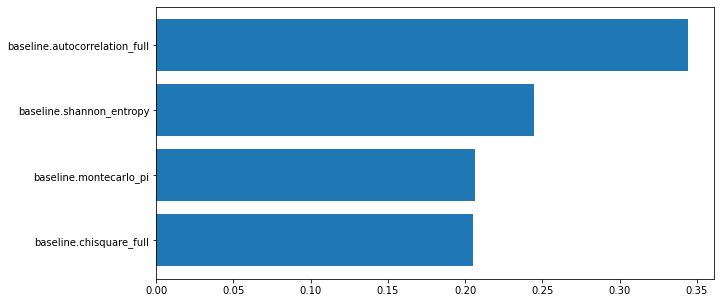

In [9]:
plt.rcParams["figure.figsize"] = (10,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)
      
plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])

In [10]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
#X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
#X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# -----------------------------------


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json["Extremities_Measured_Separately"].append("YES")
df_json["Algorithm"].append("Random Forest")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.7494177284559529
Recall    : 0.7383909287257019
Accuracy  : 0.7482288464109076
F1-score  : 0.7438634663765554


<BarContainer object of 10 artists>

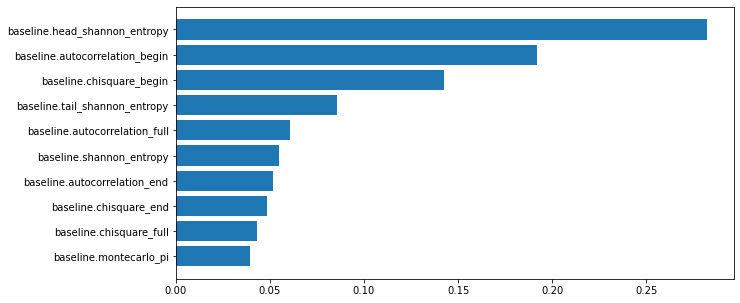

In [11]:
plt.rcParams["figure.figsize"] = (10,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)
      
plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])

In [12]:
df = pd.DataFrame(df_json)


In [13]:
df

,Extremities_Measured_Separately,Algorithm,Accuracy,Precision,Recall,F1
0,NO,Logistic Regression,0.669296,0.613218,0.899298,0.729203
1,YES,Logistic Regression,0.765072,0.728865,0.836798,0.779111
2,NO,Random Forest,0.650715,0.634393,0.695194,0.663403
3,YES,Random Forest,0.748229,0.749418,0.738391,0.743863


In [14]:
print(df.to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} & Extremities\_Measured\_Separately &            Algorithm &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
0 &                              NO &  Logistic Regression &  0.669296 &   0.613218 &  0.899298 &  0.729203 \\
1 &                             YES &  Logistic Regression &  0.765072 &   0.728865 &  0.836798 &  0.779111 \\
2 &                              NO &        Random Forest &  0.650715 &   0.634393 &  0.695194 &  0.663403 \\
3 &                             YES &        Random Forest &  0.748229 &   0.749418 &  0.738391 &  0.743863 \\
\bottomrule
\end{tabular}



### Now add kurtosis and skew to the same thing and measure again

In [15]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2 = {
    "Extremities_Measured_Separately": [],
    "Algorithm": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": []
}

df_json2["Extremities_Measured_Separately"].append("NO")
df_json2["Algorithm"].append("Logistic Regression")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.6131467501380962
Recall    : 0.8990280777537797
Accuracy  : 0.6691618767544446
F1-score  : 0.7290640394088671


In [16]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
#estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")


df_json2["Extremities_Measured_Separately"].append("YES")
df_json2["Algorithm"].append("Logistic Regression")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.7370627695256349
Recall    : 0.8305885529157667
Accuracy  : 0.769415853495522
F1-score  : 0.781035795887281


In [17]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]
X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
#estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2["Extremities_Measured_Separately"].append("NO")
df_json2["Algorithm"].append("Random Forest")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.6299686822452422
Recall    : 0.7059935205183585
Accuracy  : 0.6491110814062291
F1-score  : 0.6658179503500955


<BarContainer object of 6 artists>

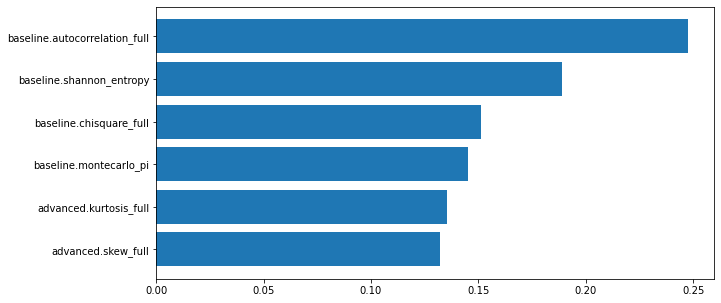

In [18]:
plt.rcParams["figure.figsize"] = (10,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)
      
plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])

In [19]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
#estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2["Extremities_Measured_Separately"].append("YES")
df_json2["Algorithm"].append("Random Forest")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.7515408848103
Recall    : 0.7406857451403888
Accuracy  : 0.7503675979147173
F1-score  : 0.7460738323475423


<BarContainer object of 16 artists>

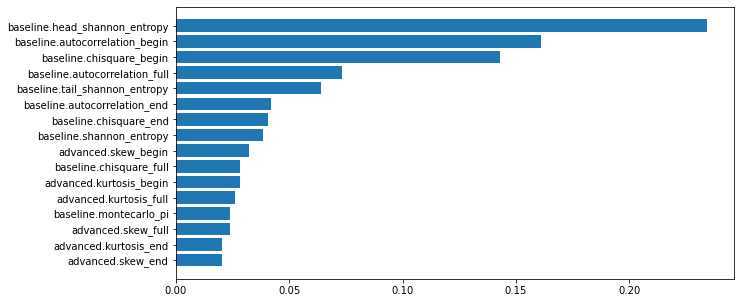

In [20]:
plt.rcParams["figure.figsize"] = (10,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)
      
plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])

In [21]:
df2 = pd.DataFrame(df_json2)
df2

,Extremities_Measured_Separately,Algorithm,Accuracy,Precision,Recall,F1
0,NO,Logistic Regression,0.669162,0.613147,0.899028,0.729064
1,YES,Logistic Regression,0.769416,0.737063,0.830589,0.781036
2,NO,Random Forest,0.649111,0.629969,0.705994,0.665818
3,YES,Random Forest,0.750368,0.751541,0.740686,0.746074


In [22]:
print(df2.to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} & Extremities\_Measured\_Separately &            Algorithm &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
0 &                              NO &  Logistic Regression &  0.669162 &   0.613147 &  0.899028 &  0.729064 \\
1 &                             YES &  Logistic Regression &  0.769416 &   0.737063 &  0.830589 &  0.781036 \\
2 &                              NO &        Random Forest &  0.649111 &   0.629969 &  0.705994 &  0.665818 \\
3 &                             YES &        Random Forest &  0.750368 &   0.751541 &  0.740686 &  0.746074 \\
\bottomrule
\end{tabular}



In [23]:
df

,Extremities_Measured_Separately,Algorithm,Accuracy,Precision,Recall,F1
0,NO,Logistic Regression,0.669296,0.613218,0.899298,0.729203
1,YES,Logistic Regression,0.765072,0.728865,0.836798,0.779111
2,NO,Random Forest,0.650715,0.634393,0.695194,0.663403
3,YES,Random Forest,0.748229,0.749418,0.738391,0.743863


In [24]:
print(df.to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} & Extremities\_Measured\_Separately &            Algorithm &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
0 &                              NO &  Logistic Regression &  0.669296 &   0.613218 &  0.899298 &  0.729203 \\
1 &                             YES &  Logistic Regression &  0.765072 &   0.728865 &  0.836798 &  0.779111 \\
2 &                              NO &        Random Forest &  0.650715 &   0.634393 &  0.695194 &  0.663403 \\
3 &                             YES &        Random Forest &  0.748229 &   0.749418 &  0.738391 &  0.743863 \\
\bottomrule
\end{tabular}



In [25]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,4.0,0.709514,0.059257,0.649111,0.664149,0.709765,0.755130,0.769416
Precision,4.0,0.682930,0.071443,0.613147,0.625763,0.683516,0.740682,0.751541
Recall,4.0,0.794074,0.087478,0.705994,0.732013,0.785637,0.847698,0.899028
F1,4.0,0.730498,0.048243,0.665818,0.713253,0.737569,0.754814,0.781036


In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,4.0,0.708328,0.056729,0.650715,0.664650,0.708762,0.752440,0.765072
Precision,4.0,0.681473,0.067670,0.613218,0.629099,0.681629,0.734003,0.749418
Recall,4.0,0.792420,0.092672,0.695194,0.727592,0.787594,0.852423,0.899298
F1,4.0,0.728895,0.048425,0.663403,0.712753,0.736533,0.752675,0.779111


In [27]:
df3 = pd.DataFrame({"With Skew and Kurtosis (averages)": df2.mean(), "Without Skew and Kurtosis (averages)": df.mean()}).T

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_26104/3964534304.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df3 = pd.DataFrame({"With Skew and Kurtosis (averages)": df2.mean(), "Without Skew and Kurtosis (averages)": df.mean()}).T


In [28]:
df3

,Accuracy,Precision,Recall,F1
With Skew and Kurtosis (averages),0.709514,0.682930,0.794074,0.730498
Without Skew and Kurtosis (averages),0.708328,0.681473,0.792420,0.728895


In [29]:
print(df3.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
With Skew and Kurtosis (averages)    &  0.709514 &   0.682930 &  0.794074 &  0.730498 \\
Without Skew and Kurtosis (averages) &  0.708328 &   0.681473 &  0.792420 &  0.728895 \\
\bottomrule
\end{tabular}



In [30]:
df.to_csv("extremity-compared-without-kurtosis.csv")
df2.to_csv("extremity-compared-with-kurtosis.csv")
df3.to_csv("with-and-without-kurtosis.csv")

In [31]:
df["Kurtosis and Skew Used"] = 0
df2["Kurtosis and Skew Used"] = 1

In [32]:
df_final = pd.concat([df, df2])

In [33]:
df_final["Extremities Measured Separately"] = df_final["Extremities_Measured_Separately"]
df_final = df_final.drop("Extremities_Measured_Separately", axis=1)

In [34]:
df_final = df_final.reset_index()

In [35]:
print(df_final.to_latex())

\begin{tabular}{lrlrrrrrl}
\toprule
{} &  index &            Algorithm &  Accuracy &  Precision &    Recall &        F1 &  Kurtosis and Skew Used & Extremities Measured Separately \\
\midrule
0 &      0 &  Logistic Regression &  0.669296 &   0.613218 &  0.899298 &  0.729203 &                       0 &                              NO \\
1 &      1 &  Logistic Regression &  0.765072 &   0.728865 &  0.836798 &  0.779111 &                       0 &                             YES \\
2 &      2 &        Random Forest &  0.650715 &   0.634393 &  0.695194 &  0.663403 &                       0 &                              NO \\
3 &      3 &        Random Forest &  0.748229 &   0.749418 &  0.738391 &  0.743863 &                       0 &                             YES \\
4 &      0 &  Logistic Regression &  0.669162 &   0.613147 &  0.899028 &  0.729064 &                       1 &                              NO \\
5 &      1 &  Logistic Regression &  0.769416 &   0.737063 &  0.830589 &  0.78

In [36]:
df_final = df_final.drop("index", axis=1)

In [38]:
df_final

,Algorithm,Accuracy,Precision,Recall,F1,Kurtosis and Skew Used,Extremities Measured Separately
0,Logistic Regression,0.669296,0.613218,0.899298,0.729203,0,NO
1,Logistic Regression,0.765072,0.728865,0.836798,0.779111,0,YES
2,Random Forest,0.650715,0.634393,0.695194,0.663403,0,NO
3,Random Forest,0.748229,0.749418,0.738391,0.743863,0,YES
4,Logistic Regression,0.669162,0.613147,0.899028,0.729064,1,NO
5,Logistic Regression,0.769416,0.737063,0.830589,0.781036,1,YES
6,Random Forest,0.649111,0.629969,0.705994,0.665818,1,NO
7,Random Forest,0.750368,0.751541,0.740686,0.746074,1,YES


In [39]:
print(df_final.to_latex())

\begin{tabular}{llrrrrrl}
\toprule
{} &            Algorithm &  Accuracy &  Precision &    Recall &        F1 &  Kurtosis and Skew Used & Extremities Measured Separately \\
\midrule
0 &  Logistic Regression &  0.669296 &   0.613218 &  0.899298 &  0.729203 &                       0 &                              NO \\
1 &  Logistic Regression &  0.765072 &   0.728865 &  0.836798 &  0.779111 &                       0 &                             YES \\
2 &        Random Forest &  0.650715 &   0.634393 &  0.695194 &  0.663403 &                       0 &                              NO \\
3 &        Random Forest &  0.748229 &   0.749418 &  0.738391 &  0.743863 &                       0 &                             YES \\
4 &  Logistic Regression &  0.669162 &   0.613147 &  0.899028 &  0.729064 &                       1 &                              NO \\
5 &  Logistic Regression &  0.769416 &   0.737063 &  0.830589 &  0.781036 &                       1 &                             YES

In [40]:
df_final.to_csv("extremity-kurtosis-skew-measured.csv")

In [41]:
df_final[df_final["Algorithm"] == "Logistic Regression"]

,Algorithm,Accuracy,Precision,Recall,F1,Kurtosis and Skew Used,Extremities Measured Separately
0,Logistic Regression,0.669296,0.613218,0.899298,0.729203,0,NO
1,Logistic Regression,0.765072,0.728865,0.836798,0.779111,0,YES
4,Logistic Regression,0.669162,0.613147,0.899028,0.729064,1,NO
5,Logistic Regression,0.769416,0.737063,0.830589,0.781036,1,YES


In [42]:
df_final[df_final["Algorithm"] != "Logistic Regression"]

,Algorithm,Accuracy,Precision,Recall,F1,Kurtosis and Skew Used,Extremities Measured Separately
2,Random Forest,0.650715,0.634393,0.695194,0.663403,0,NO
3,Random Forest,0.748229,0.749418,0.738391,0.743863,0,YES
6,Random Forest,0.649111,0.629969,0.705994,0.665818,1,NO
7,Random Forest,0.750368,0.751541,0.740686,0.746074,1,YES


In [43]:
baseline_columns = [c for c in master_df.columns if "baseline" in c.lower() and "filesize" not in c.lower()]
advanced_columns = [c for c in master_df.columns if "kurtosis" in c.lower() or "skew" in c.lower()]